Se tomatan muestras al azar del dataset de DRISHTI, al mismo se lo clasificará con el mejor modelo que tenemos *DRISHTI__augm_f-75_p-25* y se procedera a realizar el recorte de la zona disco-copa 

1. Levantar x cantidad de imagenes ala zar
2. clasificar el modelo
3. devolver la clasificacion a su tamano original
4. aplicar recorte de la mascara y de la imagen original
5. mostrar resultados (original, gt, prediction, recorte imagen, recorte mascara


In [9]:
import torch
import imageio as iio
import matplotlib.pyplot as plt
from data_processing import utils
from Models.Unet import Unet
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
from PIL import Image
from skimage.transform import resize
import torch.nn as nn
from configparser import ConfigParser
import numpy as np
from sklearn.metrics import f1_score,accuracy_score
import torchvision.transforms.functional as FT
from skimage import filters, measure
import math
import glob
import random

In [27]:
def get_OCOD_crop(mask,delta, descentro= False):
    ''' dada la mascara de una imagen, calculo la zona del disco y la copa + un delta
    se toma la zona clasificada, de ella al lado mas largo (alto u ancho) se le agrega el factor alpha, 
    el lado restante se lo acomoda para que el resultado final sea una imagen cuadrada

    update: obtener una desviacion del centro random que genere imagenes que no posean el disco en el entro
    ------------------------------------
    input
    mask: imagen binaria de la clasificacion
    delta: indice en porcentaje de que tanto mas de la mascara queremos dejan en los bordes
    descentro: booleano que nos indica si queresmos obicar el centro en otra parte de la imagen de manera aleatoria
    ------------------------------------
    output
    cordenadas para el recorte de la imagen
    centro de la imagen de recorte 
    '''

    #mask = mask[0,:,:]
    blobs_labels = measure.label(mask, background=0)
    region = measure.regionprops(blobs_labels)[0]
    
    coordinates = region.bbox #(min_row, min_col, max_row, max_col)
    coord0 = coordinates[0]
    coord1 = coordinates[1]
    coord2 = coordinates[2]
    coord3 = coordinates[3]

    sub_w = coord3 - coord1
    sub_h = coord2-coord0

    if descentro:
        max_h = int(sub_h * delta)
        max_w = int(sub_w * delta)
        rand_h = torch.randint(low=0,high=max_h+1,size=(1,))
        rand_w = torch.randint(low=0,high=max_w+1,size=(1,))
        rest_h = torch.rand(1)
        if rest_h > 0.5:
            coord0 -= rand_h
            coord2 -= rand_h
        else:
            coord0 += rand_h
            coord2 += rand_h

        rest_w = torch.rand(1)
        if rest_w > 0.5:
            coord1 -= rand_w
            coord3 -= rand_w
        else:
            coord1 += rand_w
            coord3 += rand_w




    x = coord1 + sub_w // 2
    y = coord0 + sub_h // 2
    if sub_h > sub_w: #REVISAR LOS LIMITES
        c1 = int(coord1 - coord1 * delta)
        c3 = int(coord3 + coord3 * delta)
        new_h = c3 - c1 
        if (new_h % 2) != 0:
            new_h = new_h + 1
            c3 = c3 + 1
        new_w = new_h
        half = new_w / 2
        c0 = y - half
        c2 = y + half
    else:
        
        c0 = int(coord0 - coord0 * delta)
        c2 = int(coord0 + coord0 * delta)
        new_w = c2 - c0 
        if (new_w % 2) != 0:
            new_w = new_w + 1
            c2 = c2 + 1
        new_h = new_w
        half = new_w / 2
        c1 = x - half
        c3 = x + half
    #print('MASK SHAPE: ', mask.shape)

    h,w  = mask.shape

    #VERIFICO LIMITES

    if c2 > w:
        c2 = w
    if c3 > h:
        c3 = h
    if c0 < 0:
        c0 = 0
    if c1 < 0:
        c1 = 0
        
    return int(c0),int(c1),int(c2),int(c3), (x,y)

In [11]:
def rescale_test(fundus_img,y,target_radio):
    '''
    Reescalo la imagen de test para que, en vez de recortar las imagenes y reescalar, mantener un radio similar al que obtenemos con las imagenes de test(que fueron recortadas)
    generando una imagen cuadrada del tamano similar a las imagenes de test pero que no pasaron por un cut fov
    -------------------------------------------
    input:
    fundus_img: imagen de test original
    y: mascara correspondiente a la imagen original
    target_radio: radio en el que esperamos tener en la imagen
    
    a futuro- tener en cuenta que podemos llegar a tener que realizar este metodo pero sin tener una mascara, permitir que pueda venir un y=None 
    '''
    lim_x_inf,lim_x_sup, lim_y_inf,lim_y_sup, radio = utils.crop_fov_limits(fundus_img)
    
    width, height,_ = fundus_img.shape    
    scale = target_radio / radio

    new_width = int(scale*width)
    new_height = int(scale*height)
            
    scaledImg = resize(fundus_img, (new_width,new_height))
    y_rescale = resize(y, (new_width,new_height))
    
    size = max(new_width,new_height)
    squareImg = resize(scaledImg,(size,size))
    y_squared = resize(y_rescale,(size,size))
    
    
    return squareImg, y_squared

Obtengo 10 imagenes random para analizar el recorte de las imagenes

In [12]:
base_path =  '/mnt/Almacenamiento/ODOC_segmentation/data/'
img_paths = 'images/DRISHTI/'
OD_paths = 'OD1/DRISHTI/'
model = '/mnt/Almacenamiento/ODOC_segmentation/codigo/config_files/DRISHTI_augm_f-75_p-25.ini'

imagenes= []
masks=[]
for img_p in sorted(glob.glob(base_path + img_paths + '*.png')):
        imagenes.insert(len(imagenes), img_p)
for mask_p in sorted(glob.glob(base_path + OD_paths + '*.png')):
        masks.insert(len(masks), mask_p)
print(len(imagenes))
print(len(masks))
img2process = []
mask2process = []
values = random.sample(range(1, len(imagenes)), 10)
for i in values:
    print(i)
    img2process.insert(len(img2process),imagenes[i])
    mask2process.insert(len(mask2process),masks[i])
    

50
50
12
22
32
38
46
3
16
37
17
13


In [13]:
loss = nn.CrossEntropyLoss()
config_path = '/mnt/Almacenamiento/ODOC_segmentation/codigo/config_files/DRISHTI_augm_f-75_p-25.ini'
config = ConfigParser()
config.read(config_path)

model = Unet(config, loss, model_name='prueba')

path_best = '/mnt/Almacenamiento/ODOC_segmentation/codigo/lightning_logs/drishti_model/matrix/version_19/checkpoints/DRISHTI_augm_f-75_p-25-epoch=109.ckpt'

#CARGO MODELO
model = model.load_from_checkpoint(path_best, config= config, loss=loss, model_name='prueba')

In [14]:
predictions = []
binary_pred = []
imgs = []
masks = []
for idx in range(len(img2process)):
    img = iio.imread(img2process[idx])
    mask = iio.imread(mask2process[idx])
    imgs.append(img)
    masks.append(mask)
    mask[mask < 255] = 0
    
    img,mask = rescale_test(img,mask,255)
    #TRANSFORMO LA IMAGENE EN TENSOR
    transform = transforms.ToTensor()
    img = transform(img)
    img= img.float()
    shape = img.size()

    #NORMALIZO
    mean_r = torch.mean(img[0,:,:])
    mean_g = torch.mean(img[1,:,:])
    mean_b = torch.mean(img[2,:,:])

    std_r = torch.std(img[0,:,:])+1e-6
    std_g = torch.std(img[1,:,:])+1e-6
    std_b = torch.std(img[2,:,:])+1e-6

    img = F.normalize(img, [mean_r, mean_g, mean_b], [std_r,std_g, std_b]) #normalizo la imagen

    #AGREGO LA DIMENSION BATCH SIZE
    img= torch.unsqueeze(img, 0)

    #ARREGLAR LAS DIMENSIONES PARA QUE QUEDE EN 1, 3, W, H
    y_hat = model.forward(img)
    pred = model.softmax(y_hat)
    pred_arg = torch.argmax(pred, dim=1) #BINARY IMAGE OF THE SEGMENTATION
    
    img = model.generate_img(pred_arg,transform(mask) )
    img = img[:,0,:,:]
    img = np.transpose(img, (1, 2, 0))
    binary_img = np.transpose(pred_arg, (1, 2, 0))
    
    predictions.insert(len(predictions), img)
    binary_pred.insert(len(binary_pred),binary_img)

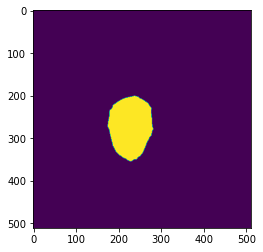

In [15]:
plt.imshow(binary_pred[9])

In [28]:
c0s = []
c1s = []
c2s = []
c3s = []
centers = []
delta = 0.1
for idx in range(len(img2process)):
    img = imgs[idx]
    mask = masks[idx]
    h,w,c = img.shape
    #print(h, w, c)

    #plt.imshow(binary_pred[idx])
    #plt.show()

    scaledPred = resize(binary_pred[idx], (h,w),preserve_range=True)
    #plt.imshow(img)
    #plt.imshow(scaledPred,alpha=0.4)
    #plt.show()

    c0,c1,c2,c3, center = get_OCOD_crop(scaledPred[:,:,0],delta,True)
    print('Coordenadas: ',c0,c1,c2,c3)
    c0s.append(c0)
    c1s.append(c1)
    c2s.append(c2)
    c3s.append(c3)
    centers.append(center)

    #plt.imshow(img[c0:c2,c1:c3])

    


Coordenadas:  628 688 1178 1238
Coordenadas:  666 548 1166 1048
Coordenadas:  501 728 1027 1254
Coordenadas:  725 755 1339 1369
Coordenadas:  791 702 1305 1216
Coordenadas:  650 720 1214 1284
Coordenadas:  676 725 1252 1301
Coordenadas:  617 655 1243 1281
Coordenadas:  760 926 930 1096
Coordenadas:  612 633 1218 1239


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


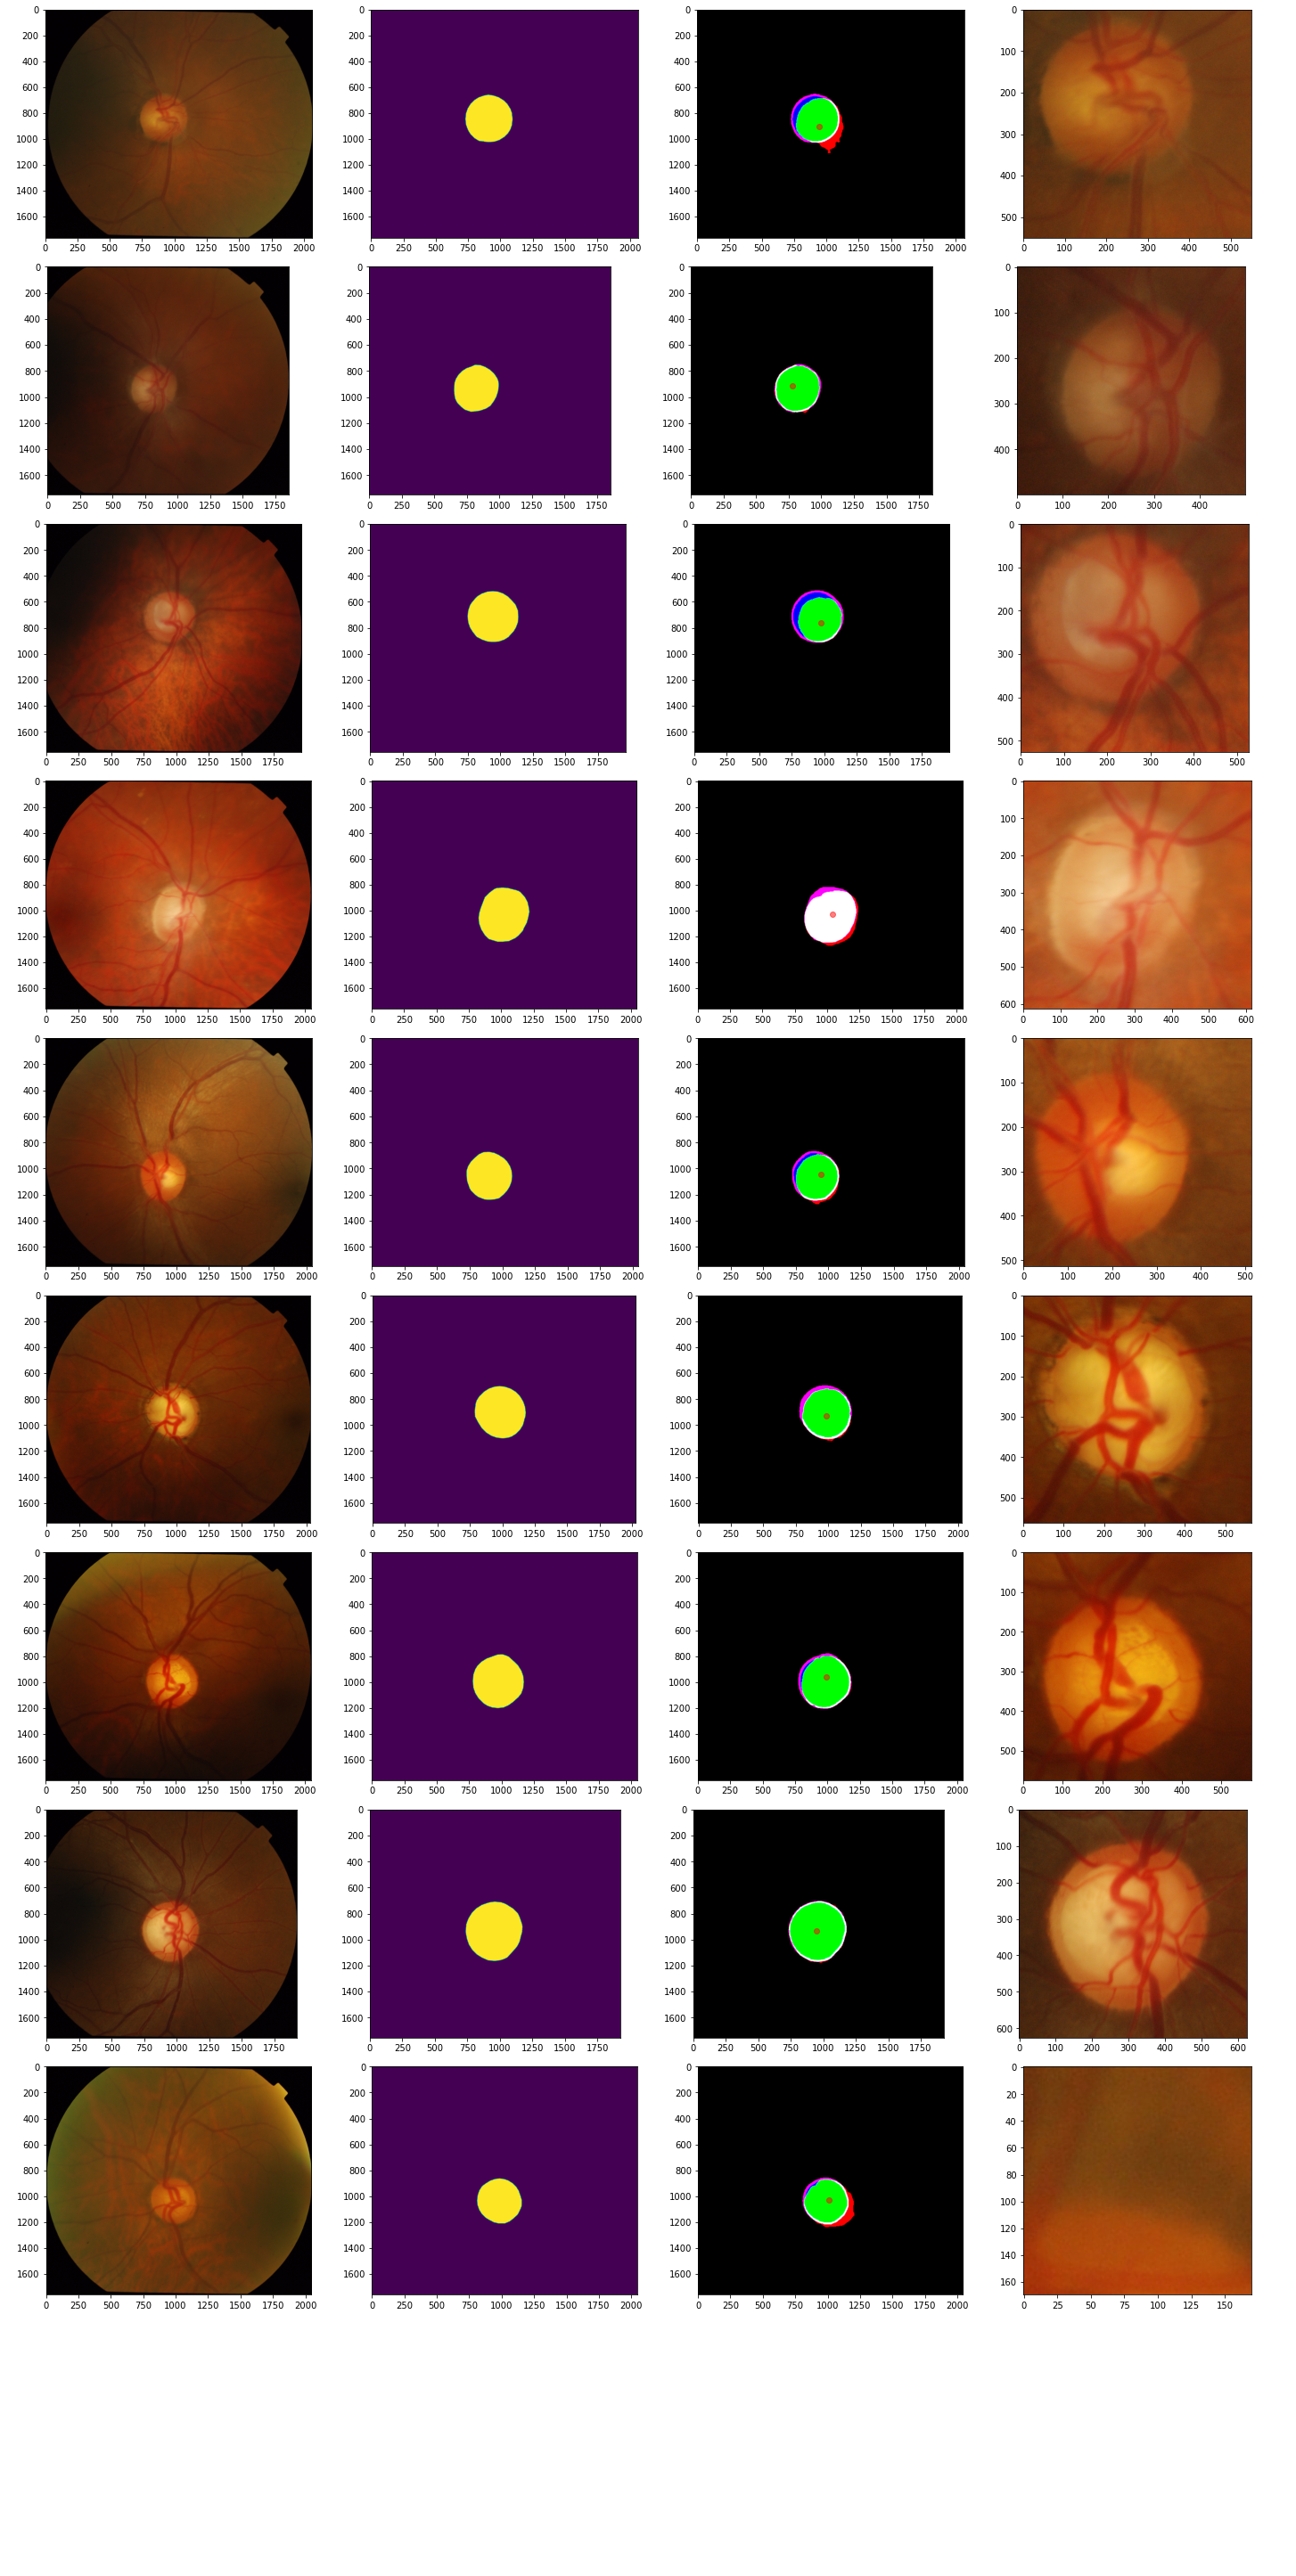

In [29]:
fig = plt.figure(constrained_layout=True,figsize=(20, 40))
subfigs = fig.subfigures(10, 1)

for i in range(9):
    (ax1, ax2, ax3, ax4) = subfigs[i].subplots(1,4)
    ax1.imshow(imgs[i])
    h,w,c = imgs[i].shape
    ax2.imshow(masks[i])

    x,y = centers[i]
    
    
    pred = predictions[i]
    pred = resize(pred, (h,w),preserve_range=True)
    ax3.imshow(pred)
    ax3.plot(x,y,'ro', alpha=0.5)

    new_img = (imgs[i])[c0s[i]:c2s[i],c1s[i]:c3s[i]]
    ax4.imshow(new_img)
    
    

In [5]:
import glob
import ntpath
path = '/mnt/Almacenamiento/ODOC_segmentation/data/images/RIM_ONE_R3'

names= []
for p in sorted(glob.glob(path + '/*')):
    names.append(ntpath.basename(p))
print(names)
print(names[-45:])



['001.png', '002.png', '003.png', '004.png', '005.png', '006.png', '007.png', '008.png', '009.png', '010.png', '011.png', '012.png', '013.png', '014.png', '015.png', '016.png', '017.png', '018.png', '019.png', '020.png', '021.png', '022.png', '023.png', '024.png', '025.png', '026.png', '027.png', '028.png', '029.png', '030.png', '031.png', '032.png', '033.png', '034.png', '035.png', '036.png', '037.png', '038.png', '039.png', '040.png', '041.png', '042.png', '043.png', '044.png', '045.png', '046.png', '047.png', '048.png', '049.png', '050.png', '051.png', '052.png', '053.png', '054.png', '055.png', '056.png', '057.png', '058.png', '059.png', '060.png', '061.png', '062.png', '063.png', '064.png', '065.png', '066.png', '067.png', '068.png', '069.png', '070.png', '071.png', '072.png', '073.png', '074.png', '075.png', '076.png', '077.png', '078.png', '079.png', '080.png', '081.png', '082.png', '083.png', '084.png', '085.png', '086.png', '087.png', '088.png', '089.png', '090.png', '091.png'